In [1]:
# Import all necessary libraries
import pandas as pd
print('Pandas version: ', pd.__version__)

import numpy as np
print('NumPy version: ', np.__version__)

import matplotlib
print('Matplotlib version: ', matplotlib.__version__)

from matplotlib import pyplot as plt

import sklearn
print('Scikit-Learn version: ', sklearn.__version__)

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

import pickle
print('Pickle version: ', pickle.format_version)

Pandas version:  1.5.0
NumPy version:  1.23.4
Matplotlib version:  3.6.1
Scikit-Learn version:  1.1.2
Pickle version:  4.0
Sys version:  3.8.1


In [2]:
# Define carts : a ticket contains one or more libelles
carts = pd.read_csv('KaDo.csv', usecols = ['TICKET_ID', 'LIBELLE'])
print('Shape of carts dataset is: ',carts.shape, '\n')
print('Number of different tickets is:', len(carts["TICKET_ID"].value_counts()))
carts.to_csv('all_carts.csv')

Shape of carts dataset is:  (7245522, 2) 

Number of different tickets is: 2734841


In [3]:
# Get a list of all unique tickets
tickets = np.unique(carts['TICKET_ID'])

In [4]:
# Encode libelles so we can use them in our algorithms 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(carts['LIBELLE'])
print('Number of items is:', len(le.classes_))

libelle_encoded = le.transform(carts['LIBELLE'])
carts['LIBELLE_ENCODED'] = libelle_encoded

# Save encoded libelles into csv file
carts_encoded = carts.drop(['LIBELLE'], axis=1)
carts_encoded.to_csv('all_carts_encoded.csv')

Number of items is: 1484


In [5]:
# Get a list of strings
# Each string corresponds to the items that are in the ticket (=cart)
def itemsListForTickets(tickets, tickets_data):
    tickets_items_list = []
    for ticket in tickets:
        tickets_items_list.append(str(list(tickets_data[tickets_data['TICKET_ID'] == ticket]['LIBELLE_ENCODED'])).split('[')[1].split(']')[0])
    with open('items_list_for_ticket.txt', 'wb') as fp:
        pickle.dump(tickets_items_list, fp)

In [3]:
# Load list of items in tickets
tickets_items_list = pickle.load(open('items_list_for_ticket.txt', 'rb'))
print('Items list for', len(carts), ' tickets')
print('A list of first 10 tickets bought items: \n', tickets_items_list[:10]) 

Items list for 7245522  tickets
A list of first 10 tickets bought items: 
 ['733, 733, 787', '469, 30, 29', '168', '706, 1279, 1340', '253, 971, 687, 1483, 823', '1164, 1177, 1145', '1082', '826', '1345, 127, 857, 1069, 336', '782, 149, 111, 925, 1238']


In [4]:
# Vectorize each string and return all vectors and feature names
def prepSparseMatrix(list_of_str):
    cv = CountVectorizer(token_pattern = r'[^\,\ ]+', lowercase = False)
    sparseMatrix = cv.fit_transform(list_of_str)
    return sparseMatrix, cv.get_feature_names_out()

In [5]:
sparseMatrix, feature_names = prepSparseMatrix(tickets_items_list)

In [9]:
# For each ticket, 0 if item is not in the cart, 1 if items is not in the cart
df_sparseMatrix = pd.DataFrame.sparse.from_spmatrix(sparseMatrix, index = tickets, columns = feature_names)
df_sparseMatrix

,0,1,10,100,1000,1001,1002,1003,1004,1005,...,990,991,992,993,994,995,996,997,998,999
32931447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32931448,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32931451,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32931452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32931453,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36529861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36529862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36529863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36529864,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Verification step : makek sure 0 and 1 are correctly distributed 
# in the sparse matrix according to the first 6 tickets initial DF
first_6_tickets_SM = carts_encoded[carts_encoded['TICKET_ID'].isin(tickets[:6])].sort_values('TICKET_ID')
print(first_6_tickets_SM.T)
print(df_sparseMatrix.loc[np.unique(first_6_tickets_SM['TICKET_ID']), list(map(str, np.unique(first_6_tickets_SM['LIBELLE_ENCODED'])))])

                  5142161   5142159   5142160   4681096   4681095   4681094  \
TICKET_ID        32931447  32931447  32931447  32931448  32931448  32931448   
LIBELLE_ENCODED       787       733       733        29        30       469   

                  1122010   1860782   1860781   1860780   3898582   3898584  \
TICKET_ID        32931451  32931452  32931452  32931452  32931453  32931453   
LIBELLE_ENCODED       168      1340      1279       706       253       687   

                  3898585   3898586   3898583   3694792   3694791   3694793  
TICKET_ID        32931453  32931453  32931453  32931454  32931454  32931454  
LIBELLE_ENCODED      1483       823       971      1177      1164      1145  
          29  30  168  253  469  687  706  733  787  823  971  1145  1164  \
32931447   0   0    0    0    0    0    0    2    1    0    0     0     0   
32931448   1   1    0    0    1    0    0    0    0    0    0     0     0   
32931451   0   0    1    0    0    0    0    0    0    0   

In [11]:
# Use elbow method to define the optimized K
# WCSS = Within Clusters Sum of Squares
class elbowMethod():
    def __init__(self, sparseMatrix):
        self.sparseMatrix = sparseMatrix
        self.wcss = list()
        self.differences = list()
    def run(self, init, upto, max_iterations = 300):
        for i in range(init, upto + 1):
            kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter = max_iterations, n_init = 10, random_state = 0)
            kmeans.fit(sparseMatrix)
            self.wcss.append(kmeans.inertia_)
        self.differences = list()
        for i in range(len(self.wcss)-1):
            self.differences.append(self.wcss[i] - self.wcss[i+1])
    def showPlot(self, boundary = 500, upto_cluster = None):
        if upto_cluster is None:
            WCSS = self.wcss
            DIFF = self.differences
        else:
            WCSS = self.wcss[:upto_cluster]
            DIFF = self.differences[:upto_cluster - 1]
        plt.figure(figsize=(15, 6))
        plt.subplot(121).set_title('Elbow Method Graph')
        plt.plot(range(1, len(WCSS) + 1), WCSS)
        plt.grid(b = True)
        plt.subplot(122).set_title('Differences in Each Two Consective Clusters')
        len_differences = len(DIFF)
        X_differences = range(1, len_differences + 1)
        plt.plot(X_differences, DIFF)
        plt.plot(X_differences, np.ones(len_differences)*boundary, 'r')
        plt.plot(X_differences, np.ones(len_differences)*(-boundary), 'r')
        plt.grid()
        plt.show()

/tmp/ipykernel_519/3841504368.py:26: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = True)


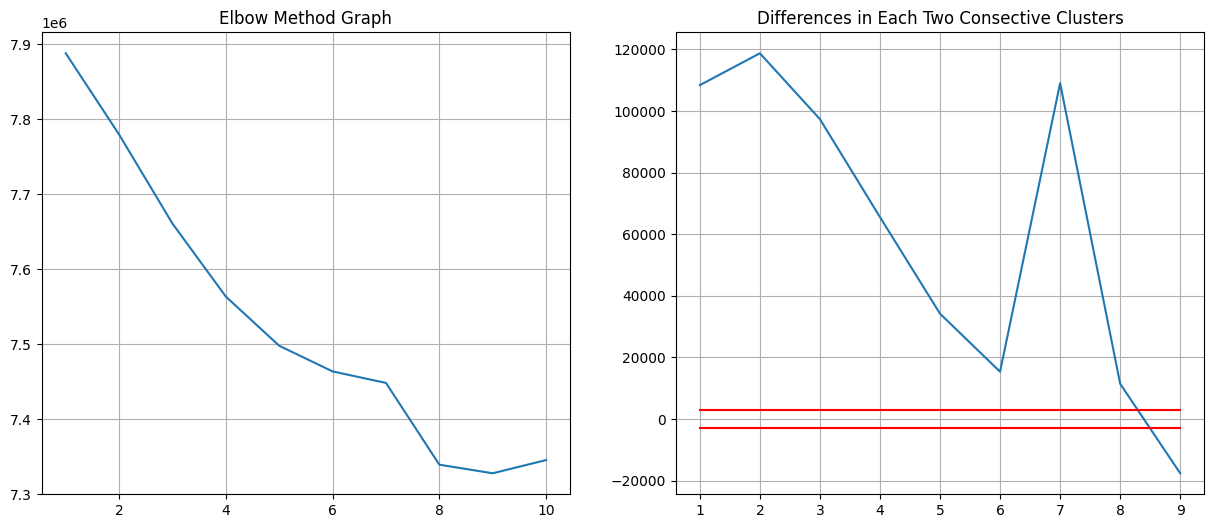

In [12]:
# Instantiate elbowMethod with our SM
elbow_method = elbowMethod(sparseMatrix) 
# Test SM with several K
elbow_method.run(1, 10)
elbow_method.showPlot(boundary = 3000)

/tmp/ipykernel_519/3841504368.py:26: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = True)


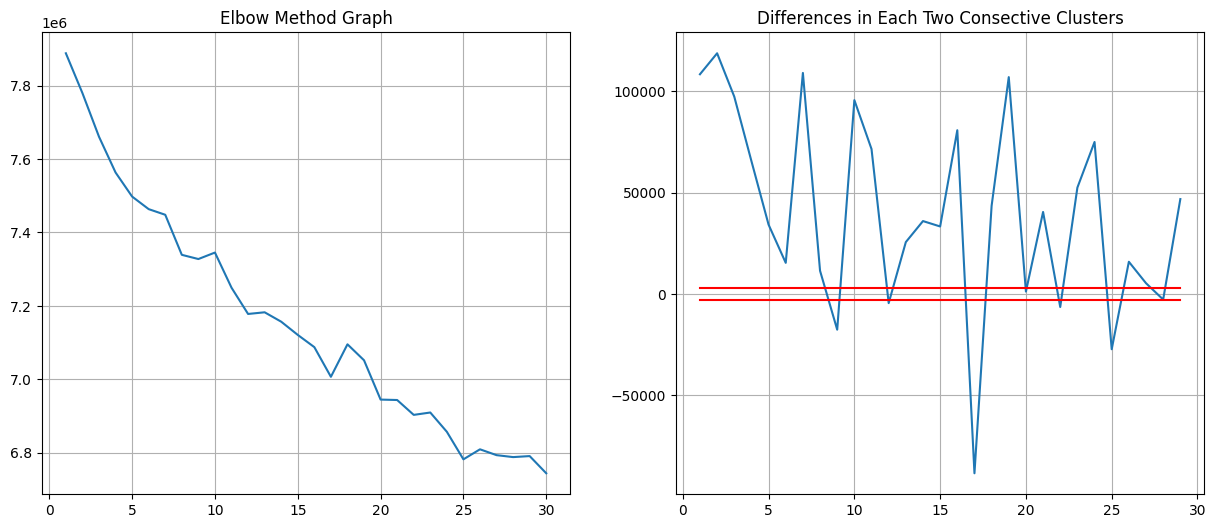

In [13]:
elbow_method.run(11, 30)
elbow_method.showPlot(boundary = 3000)